# Logistic Regression Implementation

# 1. Packages

In [8]:
from tqdm import tqdm 
from PIL import Image
from scipy import ndimage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import cv2
import joblib

# 2. Load Data - Cat and Dog from Kaggle

In [10]:
class_names = ['cats',"dogs"]
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
class_names_label

{'cats': 0, 'dogs': 1}

In [11]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

In [12]:
# 함수 코드 참조: https://www.kaggle.com/code/garginirmal/cnn-keras-image-classification
def load_data():
    # datasets 경로 설정
    datasets = ['data/cat and dog/training_set', 'data/cat and dog/test_set']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)   

        output.append((images, labels))

    return output

In [13]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/cat and dog/training_set


100%|█████████████████████████████████████████████████████████████████████████████| 4006/4006 [00:11<00:00, 346.29it/s]


Loading data/cat and dog/test_set


100%|█████████████████████████████████████████████████████████████████████████████| 1013/1013 [00:02<00:00, 363.98it/s]


In [14]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

y = 1


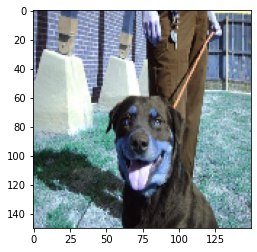

In [15]:
# 데이터 확인
index = 120
plt.imshow(train_images[index])
print("y = {0}".format(train_labels[index]))

# 3. Check data information

In [16]:
# 데이터 탐색
m_train = len(train_images)
m_test = len(test_images)
num_px = len(train_images[0])

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_images.shape))
print ("train_set_y shape: " + str(train_labels.shape))
print ("test_set_x shape: " + str(test_images.shape))
print ("test_set_y shape: " + str(test_labels.shape))

Number of training examples: m_train = 8005
Number of testing examples: m_test = 2023
Height/Width of each image: num_px = 150
Each image is of size: (150, 150, 3)
train_set_x shape: (8005, 150, 150, 3)
train_set_y shape: (8005,)
test_set_x shape: (2023, 150, 150, 3)
test_set_y shape: (2023,)


In [11]:
# flatten 실시
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T

print ("train_images_flatten shape: " + str(train_images_flatten.shape))
print ("train_set_y shape: " + str(train_labels.shape))
print ("test_images_flatten shape: " + str(test_images_flatten.shape))
print ("test_set_y shape: " + str(test_labels.shape))

train_images_flatten shape: (67500, 8005)
train_set_y shape: (8005,)
test_images_flatten shape: (67500, 2023)
test_set_y shape: (2023,)


In [12]:
train_x = train_images_flatten / 255
test_x = test_images_flatten / 255

In [13]:
train_x.shape, test_x.shape

((67500, 8005), (67500, 2023))

# 4. Logistic Regression Formula

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

# 5. Bulding the parts of Logistic Regression

In [24]:
# 1. sigmoid 함수
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [25]:
# 2 매개변수 초기화
def initialize_with_zeros(dim):
    w = np.zeros([dim, 1])
    b = float(0)
    return w, b

In [26]:
# 3. 순전파와 역전파 함수
def propagate(w, b, X, Y):
    # 예제 수
    m = X.shape[1]
    
    # forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    
    # cost function
    cost = np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / -m
    
    # back propagation
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    
    # return values
    cost = np.squeeze(np.array(cost))    
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [27]:
# 4. 최적화
def optimize(w, b, X, Y, num_iterations = 100, learning_rate = 0.009, print_cost = False):    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    #  number of interation
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        # parameters update
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    # return values
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [28]:
# 5. predict 함수 구현하기
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    
    # cut off
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    return Y_prediction

# 6. Merge all functions into a model

In [29]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 100, learning_rate = 0.5, print_cost = True):
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations=num_iterations,
                                    learning_rate=learning_rate, print_cost=print_cost)
    w, b = params["w"], params["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    # return values
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [45]:
logistic_regression_model = model(train_x, train_labels, test_x, test_labels,
                                  num_iterations=2500, learning_rate=0.0005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.673306
Cost after iteration 200: 0.666296
Cost after iteration 300: 0.661725
Cost after iteration 400: 0.658239
Cost after iteration 500: 0.655357
Cost after iteration 600: 0.652852
Cost after iteration 700: 0.650601
Cost after iteration 800: 0.648532
Cost after iteration 900: 0.646601
Cost after iteration 1000: 0.644778
Cost after iteration 1100: 0.643044
Cost after iteration 1200: 0.641385
Cost after iteration 1300: 0.639790
Cost after iteration 1400: 0.638252
Cost after iteration 1500: 0.636765
Cost after iteration 1600: 0.635325
Cost after iteration 1700: 0.633928
Cost after iteration 1800: 0.632570
Cost after iteration 1900: 0.631249
Cost after iteration 2000: 0.629962
Cost after iteration 2100: 0.628707
Cost after iteration 2200: 0.627483
Cost after iteration 2300: 0.626287
Cost after iteration 2400: 0.625118
train accuracy: 66.07120549656464 %
test accuracy: 61.047948591201184 %


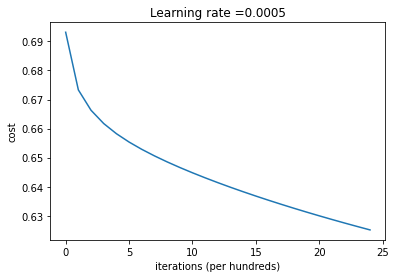

In [46]:
# 학습 과정 확인
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

In [18]:
# save model
joblib.dump(logistic_regression_model, 'logistic_regression_model_ver1')

# load model
load_model = joblib.load('logistic_regression_ver1.pkl')

# 7. Test my image

[[0.]]


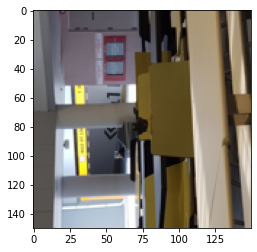

In [34]:
# change this to the name of your image file
my_image = "my_image.jpg"   

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize(IMAGE_SIZE))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(load_model["w"], load_model["b"], image)

print(my_predicted_image)